<a href="https://colab.research.google.com/github/barauna-lo/Colored_Noise/blob/main/CervejaGratis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Uma Rede neural Consegue Reproduzir uma série temporal do tipo $1/f^\beta$ atravez do seu espectro?



# Introduction

This code is the final initial version of the attempt to make different neural network architectures able to generalize and reproduce $1/f^\beta$ noise. In the format in which this code is found, it is possible to generate data of the type $1/f^\beta$, separate them into a test and validation set, and analyze the distribution of different values ​​of $\beta$s for different generated time series structures. And test the performance of different neural network architectures.

This version is being archived on GitHub for future use. Since, we are sending it to be optimized with a hyperparameter optimizer, [optuna](https://optuna.org/).

From this code, it is possible to make scientific conclusions relevant to the study of colored noise and deep learning. However, in an attempt to achieve better accuracy in the results, we will be migrating to a version in which such a hyperparameter optimizer will be tested.

Special thanks for this version go to Doctor R Sautter, a colleague, and friend to whom he made significant contributions to the design and development of neural network architectures.

# Librarys

In [5]:
#!pip install colorednoise
import colorednoise as cn

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler

import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd

import seaborn as sns
from matplotlib.gridspec import GridSpec
import time
np.random.seed(42)
torch.manual_seed(42)
sns.set_style('darkgrid')
%matplotlib inline

# Functions

In [6]:
def create_dataset(dataset, window_in=10,window_ou=10,strid=1,isTensor=True):
  '''
  NORMALIZED DATASET BETEWENN -1 AND 1
  This function will contain two vectors, dataX and dataY, the dataX will contain a set of numbers within the time series
  and the dataY will be its posterior value
  For example:
  list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
  if the window_in is equal to 3 anf window_ou equato to 2 we will have
  dataX[0] = [0,1,2] ; dataY[0] = [3,4]
  dataX[1] = [1,2,3] ; dataY[1] = [4,5]
  dataX[2] = [2,3,4] ; dataY[2] = [5,6]
  dataX[3] = [3,4,5] ; dataY[3] = [6,7]
  strid will, shift the data ex for 4:
  dataX[0] = [0,1,2] ; dataY[0] = [3,4]
  dataX[1] = [3,4,5] ; dataY[1] = [6,7]
  dataX[2] = [7,8,9] ; dataY[2] = [10,11]
  '''
  # This function must 
  dataset = dataset.reshape(len(dataset),1)
  dataset_train = dataset[:len(dataset)//2]
  dataset_test  = dataset[len(dataset)//2:]
  data_train_X, data_train_Y = [], []
  data_test_X, data_test_Y   = [], []

  for i in range(0,len(dataset_train)-window_in-window_ou+1,strid):
    _,data_norm = norm(dataset_train[i:i + window_in + window_ou])
    data_train_X.append(data_norm[0:(window_in)])
    data_train_Y.append(data_norm[ window_in:window_in + window_ou])
    #print(len(data_train_X[i]))

    _,data_norm = norm(dataset_test[i:i + window_in + window_ou])
    data_test_X.append(data_norm[0:(window_in)])
    data_test_Y.append(data_norm[window_in:window_in + window_ou])
    #print((data_train_X).astype(float))
  if isTensor:
    return torch.tensor(np.array(data_train_X)).float(), torch.tensor(np.array(data_train_Y)).float(),torch.tensor(np.array(data_test_X)).float(), torch.tensor(np.array(data_test_Y)).float()
  else:
    return np.array(data_train_X), np.array(data_train_Y),np.array(data_test_X), np.array(data_test_Y)

def create_dataset2(dataset, window_in=10,window_ou=10,strid=1,isTensor=True):
  '''
  NORMALIZED DATASET BETEWENN 0 AND 1
  This function will contain two vectors, dataX and dataY, the dataX will contain a set of numbers within the time series
  and the dataY will be its posterior value
  For example:
  list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
  if the window_in is equal to 3 anf window_ou equato to 2 we will have
  dataX[0] = [0,1,2] ; dataY[0] = [3,4]
  dataX[1] = [1,2,3] ; dataY[1] = [4,5]
  dataX[2] = [2,3,4] ; dataY[2] = [5,6]
  strid will, shift the data ex for 4:
  dataX[0] = [0,1,2] ; dataY[0] = [3,4]
  dataX[1] = [3,4,5] ; dataY[1] = [6,7]
  dataX[2] = [7,8,9] ; dataY[2] = [10,11]
  '''
  # This function must 
  dataset = dataset.reshape(len(dataset),1)
  dataset_train = dataset[:len(dataset)//2]
  dataset_test  = dataset[len(dataset)//2:]
  data_train_X, data_train_Y = [] , []
  data_test_X , data_test_Y  = [] , []

  for i in range(0,len(dataset_train)-window_in-window_ou+1,strid):
    _,data_norm = norm2(dataset_train[i:i + window_in + window_ou])
    data_train_X.append(data_norm[0:(window_in)])
    data_train_Y.append(data_norm[ window_in:window_in + window_ou])
    #print(len(data_train_X[i]))

    _,data_norm = norm2(dataset_test[i:i + window_in + window_ou])
    data_test_X.append(data_norm[0:(window_in)])
    data_test_Y.append(data_norm[window_in:window_in + window_ou])
    #print((data_train_X).astype(float))
  if isTensor:
    return torch.tensor(np.array(data_train_X)).float(), torch.tensor(np.array(data_train_Y)).float(),torch.tensor(np.array(data_test_X)).float(), torch.tensor(np.array(data_test_Y)).float()
  else:
    return np.array(data_train_X), np.array(data_train_Y),np.array(data_test_X), np.array(data_test_Y)
def generate_data(size,win_in,win_ou,title='data.pt'):
  '''
  Create a Dataset in pytorch format and save it
  trainX[i] and trainY[i] are genereted from the same time serie 
  Normalized  between [-1,1].
  data[0] = whitenoise
  data[1] = pink noise
  data[2] = rednoise
  data[3] = Turbulence
  data[i][0] = trainX
  data[i][1] = trainY
  data[i][2] = train_testX
  data[i][3] = train_testY
  list = [0,1,2,3,4,5,6,7,8,9,10,11]
  if the window_in is equal to 3 anf window_ou equal to to 2 we will have
  dataX[0] = [0,1,2] ; dataY[0] = [3,4]
  dataX[1] = [1,2,3] ; dataY[1] = [4,5]
  dataX[2] = [2,3,4] ; dataY[2] = [5,6]
  strid will, shift the data ex for 4:
  dataX[0] = [0,1,2] ; dataY[0] = [3,4]
  dataX[1] = [3,4,5] ; dataY[1] = [6,7]
  dataX[2] = [7,8,9] ; dataY[2] = [10,11]
  '''
  data = [] #Empyty Vector
  betas = [0,1,2,5/3] #Values of Betas
  for i in range(len(betas)): #loop for alocate the tensot
    trainX, trainY          = dataset_test2(betas[i],size,win_in,win_ou)
    trainX_test,trainY_test = dataset_test2(betas[i],size,win_in,win_ou)
    
    data.append([trainX,trainY,trainX_test,trainY_test])
  torch.save(data, title) #Savig the file in .pt format
  return data

def skew(t):
    """
    Computes the skewness of a :class:`Tensor`. Note: this function uses cross-approximation (:func:`torchtorch.cross()`).
    :param t: a :class:`Tensor`
    :return: a scalar
    """
    return torch.mean(((t-torch.mean(t,dim=1)[:, None])/torch.std(t,dim=1)[:, None])**3,dim=1)

def kurtosis(t, fisher=True):
    """
    Computes the kurtosis of a :class:`Tensor`. Note: this function uses cross-approximation (:func:`torchtorch.cross()`).
    :param t: a :class:`Tensor`
    :param fisher: if True (default) Fisher's definition is used, otherwise Pearson's (aka excess)
    :return: a scalar
    """
    return torch.mean(((t-torch.mean(t,dim=1)[:, None])/torch.std(t,dim=1)[:, None])**4,dim=1) - fisher*3    

def param(data):
  '''
  Print the Statiscal momentun from a givin dataset
  '''
  data = torch.tensor(data)
  output={'kurtosis':kurtosis(data),
          'mean':    torch.mean(data,dim=1),
          'skew':    skew(data),
          'std':     torch.std(data,dim=1)}
  return output    

def param_2(data):
  '''
  Print the Statiscal momentun from a givin dataset
  '''
  #data = torch.tensor(data)
  output={'kurtosis':kurtosis(data),
          'mean':    torch.mean(data,dim=1),
          'skew':    skew(data),
          'std':     torch.std(data,dim=1)}
  return output    

def norm(data):
  '''
  Normalize the dataframe from -1 to 1
  '''
  scaler = MinMaxScaler((-1,1))
  data1 = np.reshape(data,(-1, 1))
  data1 = scaler.fit_transform(data1)
  data2 = np.reshape(data1,len(data1))
  return data1, data2


def norm2(data):
  '''
  Normaliza os dados entre 0 e 1
  '''
  scaler = MinMaxScaler()
  data1 = np.reshape(data,(-1, 1))
  data1 = scaler.fit_transform(data1)
  data2 = np.reshape(data1,len(data1))
  return data1, data2  

def norm4(data):
  '''
  Normaliza os dados entre 0 e 1
  but return vectors in a single shape
  '''
  #scaler = MinMaxScaler()
  scaler = MinMaxScaler((-1,1))
  data1 = np.reshape(data,(-1, 1))
  data1 = scaler.fit_transform(data1) 
  data2 = np.reshape(data1,len(data1))
  return data2  

##################
# PLOT FUNCTIONS #
##################


def plot_psd(data,label='PSD',color='k'):
  ft = np.fft.fft(data)
  #ft = np.fft.fft(y[0,:])
  ft = np.real(ft*np.conj(ft))
  freq = np.fft.fftfreq(len(ft))
  seq = np.argsort(freq)
  a,b = np.polyfit(np.log(freq[freq>0.0]),np.log(ft[freq>0.0]),deg=1)
  text = "{} {}f + {}".format(label,np.round(a,3),np.round(b,3))
  #plota o psd
  return plt.loglog(freq[seq],ft[seq],color=color,label=text)  

def plot_test(x_,y_):
  empty = np.empty_like(x_)
  empty[:] = np.nan
  y2 = np.append(empty,y_)
  plt.plot(x_,label='Input')
  plt.plot(y2,label='Target') 


def create_dataframe(data_x,data_y,len_future=0):
     ########### CREATING DATAFRAME ###############
    #Create A inicial Dataframe with this size    
    #data_x = list(test_input_clone[0].detach().numpy().copy())
    #data_y = list(test_target_clone[0].detach().numpy().copy())
    
    #Is data_y larger than data_x or vice-versa?
    if len(data_y) > len(data_x):  
      for index in range(len(data_y) - len(data_x)):  data_x.append(np.nan)
    elif len(data_x) > len(data_y):
      for index in range(len(data_x) - len(data_y)):  data_y.append(np.nan)
    #Is x and y smaller then the future predicts?
    if len_future > len(data_x):
      for index in range(len_future - len(data_x)): data_x.append(np.nan)
    if len_future > len(data_y):
      for index in range(len_future - len(data_y)): data_y.append(np.nan)
    #Create a Dataframe
    df = pd.DataFrame()
    df.insert(0,'trainX',data_x)
    df.insert(1,'trainY',data_y)
    df.insert(2,'input_GNI',np.random.rand(len(data_x)))
    
    empty = np.empty_like(data_x)
    empty[:] = np.nan
    df.insert(len(df.columns),'loss_train',empty)
    df.insert(len(df.columns),'loss_valid',empty)
    df.insert(len(df.columns),'time',empty)
    return df


def append_dataframe(df,out,fut,i):
  '''
  Function for append the new coluns in the traingloop
  '''
  out = list(out)
  fut = list(fut)
  len_data = len(df)
  #is the output smaller then the df numer of lines?  
  if len(out) < len_data:  
    for index_1 in range(len_data - len(out)):    out.append(np.nan)
  #is the output smaller then the df numer of lines?
  if len(fut) < len_data:  
    for index_2 in range(len_data - len(fut)):    fut.append(np.nan)

  df.insert(len(df.columns),f'out{i+1}',out)
  df.insert(len(df.columns),f'fut{i+1}',fut)

def plot_results(x,y,z,w,shift_1=0,epoch=0):
  '''
  One single function to plot all the results
  '''
  plt.figure(figsize=(15,6))
  plt.suptitle(f'Results for Epoch {epoch+1}',  y=1.00, horizontalalignment='center', verticalalignment='bottom')#, fontsize = 15)
  gs = GridSpec(1,2,width_ratios=[2,1])

  plt.subplot(gs[0,0])
  plt.title("Time Series")
  plt.xlabel("x")
  plt.ylabel("y")
  #plt.xticks(fontsize=20)
  #plt.yticks(fontsize=20)

  shift_2 = len(x) + shift_1
  shift_3 = len(y) + shift_2
  plt.plot(np.arange(shift_1,shift_1+len(x)), x, color='C0',      linewidth=1.0,label='Input')            
  plt.plot(np.arange(shift_2,shift_2+len(y)), y, color='C1',      label='Target')
  plt.plot(np.arange(shift_2,shift_2+len(z)), z, color = 'brown', linewidth=1.0,label='Model Output')
  plt.plot(np.arange(shift_3,shift_3+len(w)), w, color = 'green', linewidth=1.0,label='Future')
  plt.axvline(shift_3,ls='--')
  plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.2),
           ncol=4, fancybox=True, shadow=True)#,prop={'size': 15}) 

  plt.subplot(gs[0,1])
  plot_psd(z,'Expected','brown')
  plot_psd(w,'Future','green')
  plot_psd(y,'Output','C1')
  plt.title('Power Spectrum Density')
  plt.xlabel("f (Frequency)")
  plt.ylabel("Energy (PSD)")
  plt.tight_layout()
  for k in range(n_cut): plt.axvline(x=(len(x)**(-(k+1)/n_cut)),color='r',ls='--')
  plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.3),
           ncol=1, fancybox=True, shadow=True)#,prop={'size': 15}) 

  #plt.savefig("predict%d.png"%i, dpi=200)
  plt.show()
  plt.close()


def plot_loss(train,valid,title='Loss Metrics'):
  '''
  Plot Loss metrics
  '''
  plt.figure(figsize=(15,6))
  plt.title(title)
  plt.plot(train,label='Train')
  plt.plot(valid,label='Validation')
  plt.xlabel('Epochs')
  plt.ylabel('Score')
  plt.legend()


def dt(t0,t1):
  '''
  Print Time Interval
  '''
  dt = t1-t0
  if dt < 60:           dtf = str(round(dt,3))+' s'
  elif 3600 > dt > 60:  dtf = str(round(dt/60,3))+' min'
  elif dt > 3600:       dtf = str(round(dt/3600,3))+' hours'
  return dtf      

In [26]:
## Functions for Data Analize
def dataset_test(dataset, window_in=10,window_ou=10,strid=1,isTensor=True):
  '''
  Create a data 1 sets for teste the spectra time series
  Here the data_set will be splited like in create_dataset but without test data
  All the data will be splited in two type of series.
  '''
  data_train_X, data_train_Y = [], []
  for i in range(0,len(dataset)-window_in-window_ou+1,strid):
    data_train_X.append(norm4(dataset[i:(i+window_in)]))
    data_train_Y.append(norm4(dataset[i + window_in:i + window_in + window_ou]))
  if isTensor:
    return torch.tensor(np.array(data_train_X)).float(), torch.tensor(np.array(data_train_Y)).float()
  else:
    return np.array(data_train_X), np.array(data_train_Y),np.array(data_test_X), np.array(data_test_Y)

#Data Set 03 - TrainX and TrainY from a single Series

def dataset_test2(beta,n_series, len_trainX=10,len_trainY=10,isTensor=True):
  '''
  We create a time serie and split it in trainX and trainY
  '''
  data_train_X, data_train_Y = [], []
  for i in range(n_series):
    dataset = norm4(cn.powerlaw_psd_gaussian(beta, len_trainX+len_trainY))
    data_train_X.append(dataset[:len_trainX])
    data_train_Y.append(dataset[len_trainX:])
  if isTensor:
    return torch.tensor(np.array(data_train_X)).float(), torch.tensor(np.array(data_train_Y)).float()
  else:
    return np.array(data_train_X), np.array(data_train_Y),np.array(data_test_X), np.array(data_test_Y)    


## Δβ - Diferent Index


A biblioteca pytorch possui as funções de transformada rápida de fourier (fft),respectivo conjunto de frequência (fftfreq) e logarítmo implementada já a nível vetorizado.

No entanto, foi necessário implementar manualmente o ajuste linear para medir o beta, uma boa referência (com o método dos minimos quadrados) é:

http://195.134.76.37/applets/AppletPoly/Appl_Poly2.html

In [ ]:
# class DBeta(nn.Module):
#   def __init__(self):
#     super(DBeta, self).__init__();

#   def beta(self,vet):
#     ft = torch.fft.fft(vet,dim =1)
#     ft = ft*torch.conj(ft)
#     psd = torch.real(ft)
#     freq = torch.fft.fftfreq(vet.size(dim=1))
#     freq = freq.repeat(psd.size(dim=0),1)

#     # remove frequencias negativas e zero
#     freq = freq[:,1:vet.size(dim=1)//2]
#     psd = psd[:,1:vet.size(dim=1)//2]
#     #passa para escala log
#     freq = torch.log(freq)
#     psd = torch.log(psd)

#     # calcula o angulo do ajuste linear
#     b = (psd.size(dim=1)*torch.sum(psd*freq,dim=1)-torch.sum(psd,dim=1)*torch.sum(freq,dim=1))/(psd.size(dim=1)*torch.sum(freq**2,dim=1) - (torch.sum(freq,dim=1)**2) )
#     return b
    
#   def forward(self, predictions, target):
#     square_difference = torch.square(self.beta(predictions) - self.beta(target))
#     return torch.mean(square_difference)

#   def __call__(self, predictions, target):
#     square_difference = torch.square(self.beta(predictions) - self.beta(target))
#     return torch.mean(square_difference)

## Δβλ - Separete the PSD in `n_cut` sizes
This function will return the value of the $\beta$ index from a linearized time series or, the values if de `n_cut` is larger then $1$.

In [8]:
class DBeta(nn.Module):
  def __init__(self,n_cut=1, low_freq_cut=0 ,high_freq_cut=0 ):
    super(DBeta, self).__init__();
    '''
    n_cut        - is the number of cuted betas
    low_freq_cut - Is the ignored first betas
    high_freq_cut - its the ignored last betas
    '''
    self.n_cut = n_cut
    self.high_freq_cut = high_freq_cut
    self.low_freq_cut = low_freq_cut
  def psd(self,vet):
      ft = torch.fft.fft(vet,dim =1)
      ft = ft*torch.conj(ft)
      psd = torch.real(ft)
      freq = torch.fft.fftfreq(vet.size(dim=1))
      freq = freq.repeat(psd.size(dim=0),1)
      freq = freq[:,1:vet.size(dim=1)//2]
      psd = psd[:,1:vet.size(dim=1)//2]
      return psd, freq
  
  def beta(self,vet): #n_cut number of cut for the series
    n_cut = self.n_cut
    low_freq_cut = self.low_freq_cut
    high_freq_cut = self.high_freq_cut
    psd,freq = self.psd(vet)
    beta= torch.zeros(vet.size(0), n_cut) 
    for i in range(low_freq_cut,n_cut-high_freq_cut):
      for j in range(vet.size(0)): 
        int_min,int_max = len(vet)**(-(i+1)/n_cut),len(vet)**(-(i)/n_cut)
        p = psd[j,:]
        f = freq[j,:]
        p = p[(f>int_min) & (f<int_max)]
        f = f[(f>int_min) & (f<int_max)]
        p = torch.log(p)
        f = torch.log(f)
        
        b = (p.size(0)*torch.sum(p*f)-torch.sum(p)*torch.sum(f))/(p.size(0)*torch.sum(f**2) - (torch.sum(f)**2) )
        beta[j,i] = b
    return beta
    
  def forward(self, predictions, target):
    square_difference = torch.square(self.beta(predictions) - self.beta(target))
    return torch.mean(square_difference)

  def __call__(self, predictions, target):
    square_difference = torch.square(self.beta(predictions) - self.beta(target))
    return torch.mean(square_difference)

# Data 
Here we will study the structure of differents data analizes to discute the $1/f$ aplications

## Data 1: Combined $w_1 \sin(x) + w_2 \sin(x)$

Combined $w_1 \sin(x+\theta_1) + w_2 \sin(x+\theta_2) + Noise()$

https://github.com/ageron/handson-ml2/blob/master/15_processing_sequences_using_rnns_and_cnns.ipynb

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:49: UserWarning: Attempted to set non-positive right xlim on a log-scaled axis.
Invalid limit will be ignored.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:50: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled ax

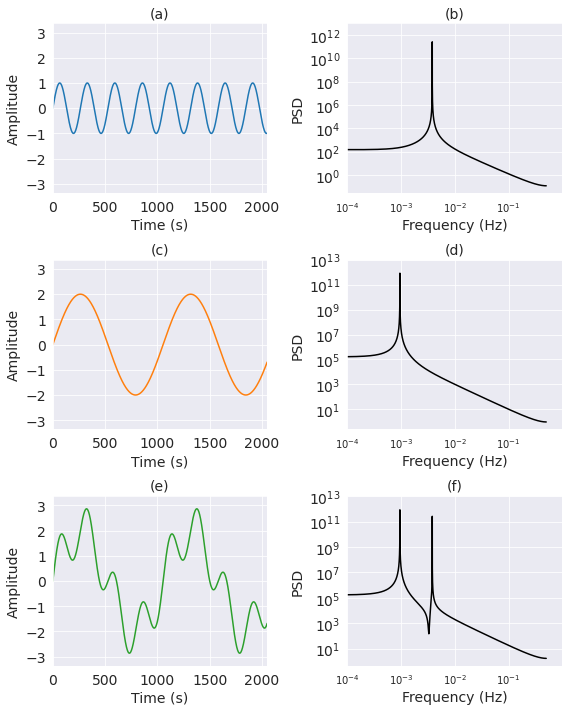

In [ ]:
def generate_time_series(batch_size, n_steps,w1=0.5,w2=0,w3=0,w4=0,f1=1000,f2=1000,f3=1000,var_freq=True):
    #offsets1, offsets2 = np.random.rand(2, batch_size, 1)
    if var_freq == True:
      freq1, freq2 = np.random.rand(2, batch_size, 1)
    else:
      freq1, freq2 = np.empty((batch_size,n_steps), np.float32), np.empty((batch_size,n_steps), np.float32), 
      freq1[:], freq2[:] = 0.5,0.5
    time = np.linspace(0, 1, n_steps)
    series =  w1 * np.sin((time ) * (freq1 * f1))  #   wave 1
    series += w2 * np.sin((time ) * (freq1 * f2)) # + wave 2
    series += w3 * np.sin((time ) * (freq1 * f3)) # + wave 2
    series += w4 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series#[..., np.newaxis].astype(np.float32)

N = 1 # number of time series
L = 2**20 # length of each sample (number of values for each sine wave)

y1 = generate_time_series(batch_size=N,
                         n_steps = L,
                         w1= 1,   w2=0,     w3=0.00,   w4 = 0.0,
                         f1= 50000,f2 = 3000,f3 = 1000, 
                         var_freq=False)

y2 = generate_time_series(batch_size=N,
                         n_steps = L,
                         w1= 0,   w2=2,     w3=0.00,   w4 = 0.0,
                         f1= 50000,f2 = 50000//4,f3 = 1000, 
                         var_freq=False)
y3 = y2[0]+y1[0]
#!wget "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
# df_airlines = pd.read_csv('airline-passengers.csv')
# airlines = df_airlines.iloc[:,1].values


plt.figure(figsize=(8,10))
font=14
def plot_sin(data,color,title):
  plt.plot(data,color=color)
  plt.xlim(0,2*1024)
  plt.ylim(min(y3)-0.5,max(y3)+0.5)
  plt.xlabel('Time (s)',fontsize=font)
  plt.xticks(fontsize=font)
  plt.yticks(fontsize=font)
  plt.ylabel('Amplitude',fontsize= font)
  plt.title(title,fontsize= font)

def plot_sinPSD(data,title):
  plot_psd(data)
  plt.xlim(1e-4,0)
  plt.ylim(0,1e13)
  plt.xlabel('Frequency (Hz)',fontsize=font)
  plt.ylabel('PSD',fontsize= font)
  plt.yticks(fontsize=font)
  plt.title(title,fontsize= font)


plt.subplot(3,2,1)
plot_sin(y1[0],'C0','(a)')


plt.subplot(3,2,2)
plot_sinPSD(y1[0],'(b)')

plt.subplot(3,2,3)
plot_sin(y2[0],'C1','(c)')

plt.subplot(3,2,4)
plot_sinPSD(y2[0],'(d)')


plt.subplot(3,2,5)
plot_sin(y3,'C2','(e)')

plt.subplot(3,2,6)
plot_sinPSD(y3,'(f)')

# plt.subplot(4,2,7)
# plt.plot(dataset,color='C3')
# plt.xlabel('Time',fontsize=font)
# plt.ylabel('Nº of Passengers',fontsize=font)
# plt.title('(e)',fontsize=font)

# plt.subplot(4,2,8)
# plot_psd(dataset)
# #plt.xlim(1e-4,0)
# #plt.ylim(0,1e13)
# plt.xlabel('Frequency (Hz)',fontsize=font)
# plt.ylabel('PSD',fontsize= font)
# plt.yticks(fontsize=font)
# plt.title('(f)',fontsize= font)


#plot_sinPSD(dataset,'(f)')

plt.tight_layout()

plt.savefig('PSD_exemple.pdf',dpi=200,bbox_inches='tight')


## Data 2: Colored Noise

In [9]:
samples = 2**20 #Numbert os points

wn = cn.powerlaw_psd_gaussian(0, samples)   #White noise generation
pn = cn.powerlaw_psd_gaussian(1, samples)   #Pink Noise generation
tn = cn.powerlaw_psd_gaussian(5/3, samples) #Turbulence data generation
rn = cn.powerlaw_psd_gaussian(2, samples)   #Red Noise gereneration
 
#Normalizing to -1 to 1 data
wn1,wn2 = norm(wn)
pn1,pn2 = norm(pn)
rn1,rn2 = norm(rn) 
tn1, tn2 = norm(tn) 

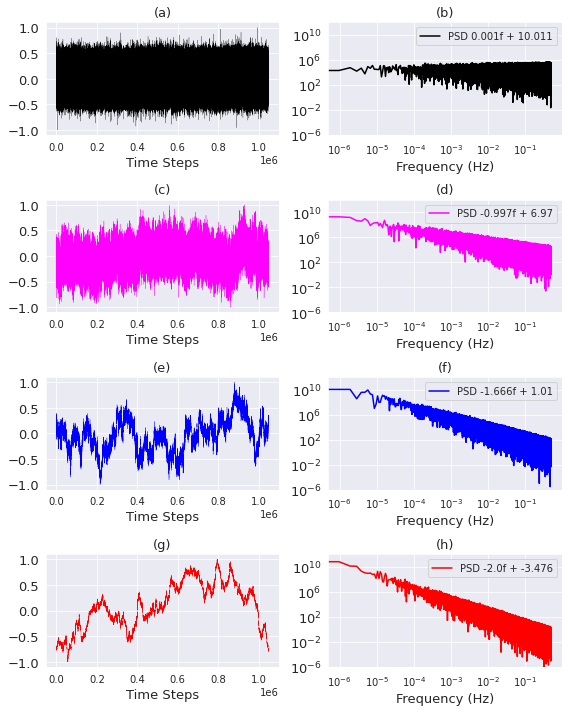

In [ ]:
plt.figure(figsize=(8,10))
font=13
plt.subplot(4,2,1)
plt.plot(wn2,color='black',alpha=1,linewidth=0.2)
plt.title('(a)',fontsize=font)
plt.xlabel('Time Steps',fontsize=font)
plt.yticks(fontsize=font)

plt.subplot(4,2,2)
plot_psd(wn2)
plt.ylim(1e-6,1e12)
plt.yticks(fontsize=font)
plt.legend()
plt.xlabel('Frequency (Hz)',fontsize=font)
plt.title('(b)',fontsize=font)

plt.subplot(4,2,3)
plt.plot(pn2,color='magenta',alpha=1,linewidth=0.3)
plt.yticks(fontsize=font)
plt.title('(c)',fontsize=font)
plt.xlabel('Time Steps',fontsize=font)

plt.subplot(4,2,4)
plot_psd(pn2,color='magenta')
plt.ylim(1e-6,1e12)
plt.xlabel('Frequency (Hz)',fontsize=font)
plt.yticks(fontsize=font)
plt.legend()
plt.title('(d)',fontsize=font)

plt.subplot(4,2,5)
plt.plot(tn2,color='blue',linewidth=0.3)
plt.yticks(fontsize=font)
plt.title('(e)',fontsize=font)
plt.xlabel('Time Steps',fontsize=font)

plt.subplot(4,2,6)
plot_psd(tn2,color='blue')
plt.ylim(1e-6,1e12)
plt.xlabel('Frequency (Hz)',fontsize=font)
plt.yticks(fontsize=font)
plt.title('(f)',fontsize=font)
plt.legend()

plt.subplot(4,2,7)
plt.plot(rn2,color='red',linewidth=0.3)
plt.yticks(fontsize=font)
plt.title('(g)',fontsize=font)
plt.xlabel('Time Steps',fontsize=font)

plt.subplot(4,2,8)
plot_psd(rn2,color='red')
plt.ylim(1e-6,1e12)
plt.xlabel('Frequency (Hz)',fontsize=font)
plt.yticks(fontsize=font)
plt.title('(h)',fontsize=font)
plt.legend()

plt.tight_layout()
#plt.savefig('PSD_all_data.pdf',dpi=200,bbox_inches='tight')


plt.show()

# Creating `trainX` and `trainY`

In [ ]:
# ### ⚠️⚠️⚠️⚠️⚠️ COMENTEND ⚠️⚠️⚠️⚠️⚠️⚠️ ###
# #This cell will creat and save large among of data
# #Generate and Save All data
# win_in = [1024,1024,1024,2048,2048,2048,4096,4096,4096]
# win_ou = [1024,2048,4096,1024,2048,4096,1024,2048,4096]
# n_series = 2**13

# for i in range(len(win_in)):
#   data = generate_data(n_series,win_in[i],win_ou[i],
#                      title=f'data_X{win_in[i]}_Y{win_ou[i]}_n{n_series}.pt')
# # Zip File 📦
# !zip -r /content/All_Files.zip /content  

# ##### 🆙🆙🆙🆙🆙🆙 LOAD THE DATA 🆙🆙🆙🆙🆙🆙🆙 #####
# win_in = 1024
# win_ou = 2048
# n_series = 2**13
# data1 = torch.load(f'data_X{win_in}_Y{win_ou}_n{n_series}.pt')
# trainX, trainY, trainX_test,trainY_test = data1[2][0],data1[2][1],data1[2][2],data1[2][3]

In [98]:
win_in = 1024
win_ou = 1024*2
#jump = 512*16*4
n_series = 16

#dataset = rn
#trainX, trainY, trainX_test,trainY_test = create_dataset(dataset,win_in,win_ou,jump,isTensor=True)
data = generate_data(n_series,win_in,win_ou,
                     title=f'data_X{win_in}_Y{win_ou}_n{n_series}.pt')
beta = 2
trainX, trainY, trainX_test,trainY_test = data[beta][0],data[beta][1],data[beta][2],data[beta][3]

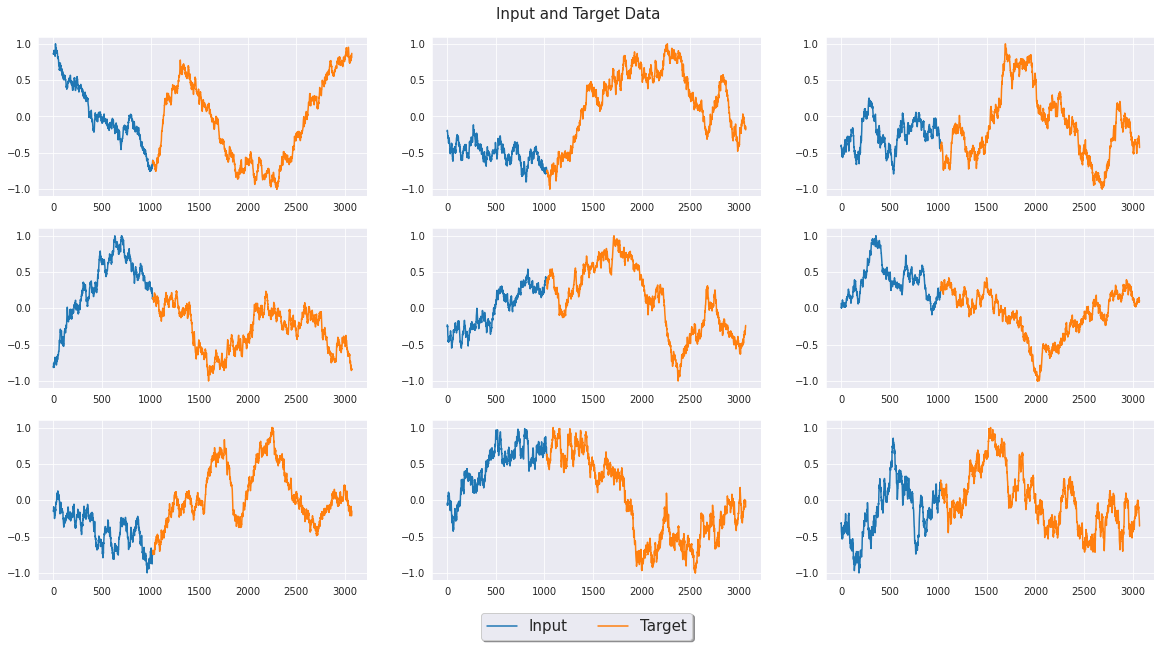

In [99]:
#Ploting a Sequence of Series for the dataframe
plt.figure(figsize=(20,10))
plt.suptitle('Input and Target Data',  y=0.90, horizontalalignment='center', verticalalignment='bottom', fontsize = 15)
for k in range(9):
  plt.subplot(3,3,k+1)
  plot_test(trainX_test[k],trainY_test[k])
plt.legend(loc='lower center', bbox_to_anchor=(-0.73, -0.42),
           ncol=4, fancybox=True, shadow=True,prop={'size': 15}) 
plt.show()

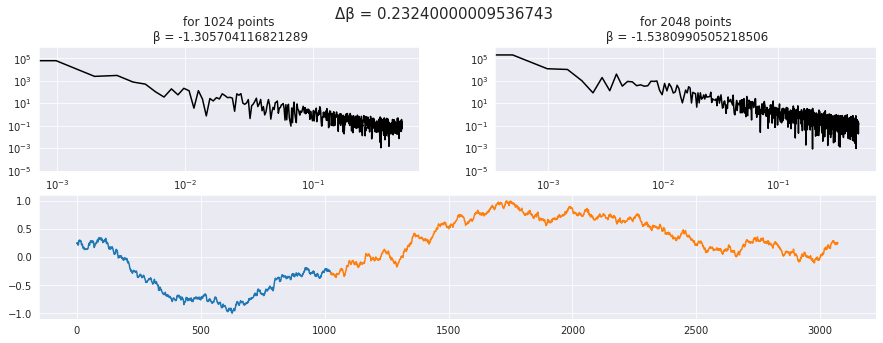

In [104]:
#Ploting train and target data with his power spectruns
k = 10
l = DBeta(2)
plt.figure(figsize=(15,5))
plt.suptitle(f'Δβ = {round((l.beta(torch.Tensor(trainX))[k].detach().numpy()[0] - l.beta(torch.Tensor(trainY))[k].detach().numpy()[0]),4)}',  y=0.95, horizontalalignment='center', verticalalignment='bottom', fontsize = 15)
plt.subplot(2,2,1)
plot_psd(trainX[k])
plt.ylim(1e-5,1e6)
plt.title(f'for {len(trainX[k])} points\n β = {l.beta(torch.Tensor(trainX))[k].detach().numpy()[0]}')
plt.subplot(2,2,2)
plt.title(f'for {len(trainY[k])} points\n β = {l.beta(torch.Tensor(trainY))[k].detach().numpy()[0]}')
plot_psd(trainY[k])
plt.ylim(1e-5,1e6)
plt.subplot(2,2,(3,4))
plot_test(trainX[k],trainY[k])
#plt.text(1, 1, r'$\mathcal{A}\mathrm{sin}(2 \omega t)$')

# Data Analysis

In [ ]:
# win_in = 128
# win_ou = 2048*2
# jump   = 512

# #Data Set 01 - Recorted dataset
# trainX_wn_01, trainY_wn_01 = dataset_test(wn,win_in,win_ou,jump,isTensor=True)
# trainX_pn_01, trainY_pn_01 = dataset_test(pn,win_in,win_ou,jump,isTensor=True)
# trainX_rn_01, trainY_rn_01 = dataset_test(rn,win_in,win_ou,jump,isTensor=True)

# #Data Set 02 - Generated All Single Series

# trainX_wn_02,trainX_pn_02,trainX_rn_02 = [],[],[]
# trainY_wn_02,trainY_pn_02,trainY_rn_02 = [],[],[]
# for i in range(len(trainX_wn_01)):
#   trainX_wn_02.append(norm4(cn.powerlaw_psd_gaussian(0, win_in)))
#   trainY_wn_02.append(norm4(cn.powerlaw_psd_gaussian(0, win_ou)))
#   trainX_pn_02.append(norm4(cn.powerlaw_psd_gaussian(1, win_in)))
#   trainY_pn_02.append(norm4(cn.powerlaw_psd_gaussian(1, win_ou)))
#   trainX_rn_02.append(norm4(cn.powerlaw_psd_gaussian(2, win_in)))
#   trainY_rn_02.append(norm4(cn.powerlaw_psd_gaussian(2, win_ou)))

# trainX_wn_02, trainY_wn_02= torch.tensor(trainX_wn_02), torch.tensor(trainY_wn_02)
# trainX_pn_02, trainY_pn_02= torch.tensor(trainX_pn_02), torch.tensor(trainY_pn_02)
# trainX_rn_02, trainY_rn_02= torch.tensor(trainX_rn_02), torch.tensor(trainY_rn_02)

# #Data Set 03 - TrainX and TrainY from a single Series
# trainX_wn_03, trainY_wn_03 = dataset_test2(0,len(trainX_wn_01),win_in,win_ou)
# trainX_pn_03, trainY_pn_03 = dataset_test2(1,len(trainX_wn_01),win_in,win_ou)
# trainX_rn_03, trainY_rn_03 = dataset_test2(2,len(trainX_wn_01),win_in,win_ou)

In [ ]:
# plt.figure(figsize=(20,10))
# plt.suptitle('Diferents Data Set',  y=0.90, horizontalalignment='center', verticalalignment='bottom', fontsize = 15)
# k=0
# plt.subplot(3,3,1)
# plt.ylabel(f'Splited from 2^{int(np.log2(len(wn)))} points')
# #plt.title('White Noise')
# plot_test(trainX_wn_01[k],trainY_wn_01[k])
# plt.subplot(3,3,2)
# #plt.title('Pink Noise')
# plot_test(trainX_pn_01[k],trainY_pn_01[k])
# plt.subplot(3,3,3)
# #plt.title('Red Noise')
# plot_test(trainX_rn_01[k],trainY_rn_01[k])

# plt.subplot(3,3,4)
# plt.ylabel(f'Created separately')
# plot_test(trainX_wn_02[k],trainY_wn_02[k])
# plt.subplot(3,3,5)
# plot_test(trainX_pn_02[k],trainY_pn_02[k])
# plt.subplot(3,3,6)
# plot_test(trainX_rn_02[k],trainY_rn_02[k])    

# plt.subplot(3,3,7)
# plt.ylabel(f'Splited from 1 singel serie')
# plot_test(trainX_wn_03[k],trainY_wn_03[k])
# plt.subplot(3,3,8)
# plot_test(trainX_pn_03[k],trainY_pn_03[k])
# plt.subplot(3,3,9)
# plot_test(trainX_rn_03[k],trainY_rn_03[k])

# plt.legend(loc='lower center', bbox_to_anchor=(-0.73, -0.42),
#            ncol=4, fancybox=True, shadow=True,prop={'size': 15}) 
# plt.show()

In [ ]:
# #l = DBeta(n_cut)

# bet_index = 2
# n_cut = 3
# n_rowns = 4
# #vets = [trainX_wn_01,trainX_wn_02,trainX_wn_03]
# #vets = [trainX_pn_01,trainX_pn_02,trainX_pn_03]
# vets = [trainX_rn_01,trainX_rn_02,trainX_rn_03]


# def plot_ncut_beta(bet = 0,n_cut = 4,vet = trainX_wn_01,n_rowns = 1,c_colum = 1,possi1  = 1,title=None): 
#   plt.subplot(n_rowns,c_colum,possi1)
#   for i in range(0,n_cut): 
#     l = DBeta(n_cut)#(i+1)#??????????  
#     sns.distplot(-l.beta(vet)[:,i],label=f'Cut {i+1}')
#   plt.axvline(bet_index,color = 'r', linestyle='--')
#   #plt.title(title)
#   plt.legend()

# def plot_cuted_psd(bet = 0,n_cut = 4,vet = trainX_wn_01,n_rowns = 1,c_colum = 1,possi2  = 1,title=None):
#   plt.subplot(n_rowns,c_colum,possi2)
#   plot_psd(vet[0])
#   for i in range(n_cut):  
#     plt.axvline(x=(len(vet[0])**(-(i+1)/n_cut)),color='r',ls='--')


# plt.figure(figsize=(20,16))
# plt.suptitle('β Distribuition  fot Diferents Data Set',  y=0.90, horizontalalignment='center', verticalalignment='bottom', fontsize = 15)
# for i in range(1,n_cut+1):
#   plot_cuted_psd(bet = bet_index,n_cut =i,vet = vets[0], n_rowns = n_rowns,c_colum = n_cut,possi2  = i        ,title=f'{1}º cut')
#   plot_ncut_beta(bet = bet_index,n_cut =i,vet = vets[0], n_rowns = n_rowns,c_colum = n_cut,possi1  = (n_cut+i),title=f'{i}º cut')
#   plot_ncut_beta(bet = bet_index,n_cut =i,vet = vets[1], n_rowns = n_rowns,c_colum = n_cut,possi1  = (2*n_cut+i),title=f'{i}º cut')
#   plot_ncut_beta(bet = bet_index,n_cut =i,vet = vets[2], n_rowns = n_rowns,c_colum = n_cut,possi1  = (3*n_cut+i),title=f'{i}º cut')

In [ ]:
# print('kurtosis',kurtosis(torch.tensor([wn2])))
# print('mean',torch.mean(torch.tensor([wn2])))
# print('skew',skew(torch.tensor([wn2])))
# print('std',torch.std(torch.tensor([wn2])))

## Plot on Violin


In [ ]:
# #Ploting Paramenters

# #df = pd.DataFrame({'White Noise':wn_Y,'Pink Noise':pn_Y,'Red Noise':rn_Y})
# n_cut = 6
# l = DBeta(n_cut)
# #data = vets[0]
# bet_index = 2
# n_rowns = 4
# #vets = [trainX_rn_01,trainX_rn_02,trainX_rn_03]
# vets = [trainX,trainY]
# data_name = "Sin"

# def beta_df(data,data_name,n_cut):
#   cuted_beta = [] #empty vector
#   for i in range(n_cut): cuted_beta.append(-l.beta(data)[:,i]) #Alocating betas from the functions
#   sum = torch.cat(cuted_beta).detach().numpy() #concatoneting all data in ine single numpy vector
#   _df = pd.DataFrame() #Creating a dataframe
#   _df.insert(0,data_name,sum) #Inserting sum on data frame
#   _ds = [] #creating a vector for cut type
#   for i in range(len(cuted_beta)): 
#     for j in range(cuted_beta[i].size(0)): _ds.append(f'Cut {i}')
#   _df.insert(1,'ds',_ds)
#   return _df


# def plot_ncut_beta_violin(bet = 0,n_cut = 4,vet = vets[0],n_rowns = 1,c_colum = 1,possi1  = 1,title=None): 
#   plt.subplot(n_rowns,c_colum,possi1)
#   for i in range(0,n_cut): 
#     l = DBeta(n_cut)#(i+1)#??????????  
#     sns.violinplot(x='ds',y=data_name,data=beta_df(vet,data_name,n_cut))
#   #plt.title(title)
#   #plt.legend()

# def plot_cuted_psd(bet = 0,n_cut = 4,vet = vets[0],n_rowns = 1,c_colum = 1,possi2  = 1,title=None):
#   plt.subplot(n_rowns,c_colum,possi2)
#   plot_psd(vet[0])
#   for i in range(n_cut):  
#     plt.axvline(x=(len(vet[0])**(-(i+1)/n_cut)),color='r',ls='--')

# plt.figure(figsize=(20,16))
# plt.suptitle('β Distribuition  fot Diferents Data Set',  y=0.90, horizontalalignment='center', verticalalignment='bottom', fontsize = 15)
# for i in range(1,n_cut+1):
#   plot_cuted_psd(bet = bet_index,n_cut =i,vet = vets[0], n_rowns = n_rowns,c_colum = n_cut,possi2  = i        ,title=f'{1}º cut')
#   plot_ncut_beta_violin(bet = bet_index,n_cut =i,vet = vets[0], n_rowns = n_rowns,c_colum = n_cut,possi1  = (n_cut+i),title=f'{i}º cut')
#   plot_ncut_beta_violin(bet = bet_index,n_cut =i,vet = vets[1], n_rowns = n_rowns,c_colum = n_cut,possi1  = (2*n_cut+i),title=f'{i}º cut')
#   #plot_ncut_beta_violin(bet = bet_index,n_cut =i,vet = vets[2], n_rowns = n_rowns,c_colum = n_cut,possi1  = (3*n_cut+i),title=f'{i}º cut')

In [ ]:
# #Ploting Paramenters

# #df = pd.DataFrame({'White Noise':wn_Y,'Pink Noise':pn_Y,'Red Noise':rn_Y})
# n_cut = 3
# l = DBeta(n_cut)
# data = vets[0]
# bet_index = 2
# n_rowns = 4
# vets = [trainY_rn_01,trainY_rn_02,trainY_rn_03]
# data_name = "Red Noise"

# def beta_df(data,data_name,n_cut):
#   cuted_beta = [] #empty vector
#   for i in range(n_cut): cuted_beta.append(-l.beta(data)[:,i]) #Alocating betas from the functions
#   sum = torch.cat(cuted_beta).detach().numpy() #concatoneting all data in ine single numpy vector
#   _df = pd.DataFrame() #Creating a dataframe
#   _df.insert(0,data_name,sum) #Inserting sum on data frame
#   _ds = [] #creating a vector for cut type
#   for i in range(len(cuted_beta)): 
#     for j in range(cuted_beta[i].size(0)): _ds.append(f'Cut {i}')
#   _df.insert(1,'ds',_ds)
#   return _df


# def plot_ncut_beta_violin(bet = 0,n_cut = 4,vet = trainY_wn_01,n_rowns = 1,c_colum = 1,possi1  = 1,title=None): 
#   plt.subplot(n_rowns,c_colum,possi1)
#   for i in range(0,n_cut): 
#     l = DBeta(n_cut)#(i+1)#??????????  
#     sns.violinplot(x='ds',y=data_name,data=beta_df(vet,data_name,n_cut))
#   #plt.title(title)
#   #plt.legend()

# def plot_cuted_psd(bet = 0,n_cut = 4,vet = trainX_wn_01,n_rowns = 1,c_colum = 1,possi2  = 1,title=None):
#   plt.subplot(n_rowns,c_colum,possi2)
#   plot_psd(vet[0])
#   for i in range(n_cut):  
#     plt.axvline(x=(len(vet[0])**(-(i+1)/n_cut)),color='r',ls='--')

# plt.figure(figsize=(20,16))
# plt.suptitle('β Distribuition  fot Diferents Data Set',  y=0.90, horizontalalignment='center', verticalalignment='bottom', fontsize = 15)
# for i in range(1,n_cut+1):
#   plot_cuted_psd(bet = bet_index,n_cut =i,vet = vets[0], n_rowns = n_rowns,c_colum = n_cut,possi2  = i        ,title=f'{1}º cut')
#   plot_ncut_beta_violin(bet = bet_index,n_cut =i,vet = vets[0], n_rowns = n_rowns,c_colum = n_cut,possi1  = (n_cut+i),title=f'{i}º cut')
#   plot_ncut_beta_violin(bet = bet_index,n_cut =i,vet = vets[1], n_rowns = n_rowns,c_colum = n_cut,possi1  = (2*n_cut+i),title=f'{i}º cut')
#   plot_ncut_beta_violin(bet = bet_index,n_cut =i,vet = vets[2], n_rowns = n_rowns,c_colum = n_cut,possi1  = (3*n_cut+i),title=f'{i}º cut')

# Models

A ideia dessa rede é evitar a dissonância informacional. A rede guarda internamente a memória de curto prazo, ao informar novamente a rede sobre o estado de curto prazo, poderemos estar reintroduzindo informação que já foi filtrada/descartada. Esta reintrodução de dado espúrio estamos chamando de dissonância informacional. 

## Training Loop

In [60]:
def training_loop(n_epochs,     #Number of epochs
                  model,        #Model used for traingin 
                  optimiser,    #Optimizer criteria used in the model
                  loss_fn,      #Loss Functions 
                  train_input,  #Train data flow in the model traing
                  train_target, #Target data for traing
                  test_input,   #Data who will not be user for update weigths
                  test_target,  # "    "   "   "
                  future=0,     # How many points in the future the model will generate
                  n_cut=1,      # Number of division of frequency in frequenct space
                  file_name='result.plk', #data Outputa name
                  plot_results_during_traing=True): #Do you wanna see plots during the trainig?
    loss_train_history = [] #Vector for the Loss Plot
    loss_valid_history = [] #Vector for the Loss Plot
    train_input_clone = torch.clone(train_input)   #Cloning train_input
    train_target_clone = torch.clone(train_target) #Cloning target_input 
    test_input_clone = torch.clone(test_input)     #Cloning test_input
    test_target_clone = torch.clone(test_target)   #Cloning targe_input

    n = test_input_clone.shape[1] # 999
    m = test_target_clone.shape[1]


    ########## CREATING DATAFRAME ###############
    # a dataframe with 1 test time series, 1 target test time series, noise, time of runing loss traing and acuracy, time of each epochs and output anf future for each epochs
    df = create_dataframe(list(test_input_clone[0].detach().numpy().copy()),list(test_target_clone[0].detach().numpy().copy()))
     
    #LOOP TRAINING
    for i in range(n_epochs): #Runing in all the epochs
        t0 = time.time()      #Saving time of runing
        shuffle            = torch.randperm(train_input_clone.size(0)) #Embaralhando a orgem das séries
        train_input_clone  = train_input_clone[shuffle,:]
        train_target_clone = train_target_clone[shuffle,:]
        test_input_clone   = test_input_clone[shuffle,:]
        test_target_clone  = test_target_clone[shuffle,:]
        def closure():
            optimiser.zero_grad()
            out = model(train_input_clone,abs(train_target_clone.size(1)-train_input_clone.size(1))) #independente de quanto seja o valor de saída a mais no future, ele ira gerar um vetor de tamanho igual ao tamanho de saída. Dessa forma subtração dará o valor que queremos de saída a mais
            loss = loss_fn(out[:,:train_target_clone.size(1)], train_target_clone) #Calculate de loss functions only for the point were the data was generated
            loss.backward() #update weigts
            return loss     #Return Loss value
        optimiser.step(closure) #Call the funcution
        with torch.no_grad(): #torch.no_grad() do not update weigths
            pred2 = model(test_input_clone,future_preds=test_target_clone.size(1)+future) #Predict values for test points
            y2    = pred2.detach().numpy().copy()
            y2 = y2[:,test_input_clone.size(1):] #take only the non input data
        for j in range(0,len(y2)): y2[j] = norm4(y2[j]) #NORMALIZATION (-1 a 1)

        append_dataframe(df,list(y2[0,32:m]),list(y2[0,m:]),i) #Append this results in the dataframe

        if plot_results_during_traing:          
          # if model.isGNI:
          #   x = df.input_GNI
          # else:
          x = df[~df.trainX.isnull()].trainX
          y = df[~df.trainY.isnull()].trainY
          z = df[~df[f'out{i+1}'].isnull()][f'out{i+1}']
          w = df[~df[f'fut{i+1}'].isnull()][f'fut{i+1}']
          plot_results(x,y,z,w,32,i)

        #SAVING LOSS TRAIN
        out1 = model(train_input) #Pass the values 
        loss_train_print = loss_fn(out1, train_target)
        loss_train_history.append(loss_train_print.detach().numpy())
        #SAVING LOSS VALIDATION
        out2 = model(test_input)
        loss_valid_print = loss_fn(out2, test_target)
        loss_valid_history.append(loss_valid_print.detach().numpy())
        
        df['loss_train'].loc[i] = loss_train_history[i]
        df['loss_valid'].loc[i] = loss_valid_history[i]
        t1 = time.time()
        df['time'].iloc[i] = t1-t0
        df.to_pickle(file_name)    
        dft = dt(t0,t1)
        print("Epoch: {}, Train Loss: {}, Validation Loss: {}, Time {}".format(i+1, loss_train_history[i],loss_valid_history[i],dft))

In [50]:
# def init_datafram(data_x,data_y):
#      ########### CREATING DATAFRAME ###############
#     #Create A inicial Dataframe with this size    
#     data_x = list(test_input_clone[0].detach().numpy().copy())
#     data_y = list(test_target_clone[0].detach().numpy().copy())
    
#     #Is data_y larger than data_x or vice-versa?
#     if len(data_y) > len(data_x):  
#       for index in range(len(data_y) - len(data_x)):  data_x.append(np.nan)
#     elif len(data_x) > len(data_y):
#       for index in range(len(data_x) - len(data_y)):  data_y.append(np.nan)
#     #Is x and y smaller then the future predicts?
#     if len_future > len(data_x):
#       for index in range(len_future - len(data_x)): data_x.append(np.nan)
#     if len_future > len(data_y):
#       for index in range(len_future - len(data_y)): data_y.append(np.nan)
#     #Create a Dataframe
#     df = pd.DataFrame()
#     df.insert(0,'trainX',data_x)
#     df.insert(1,'trainY',data_y)
#     df.insert(2,'input_GNI',np.random.rand(len(data_x)))
    
#     empty = np.empty_like(data_x)
#     empty[:] = np.nan
#     df.insert(len(df.columns),'loss_train',empty)
#     df.insert(len(df.columns),'loss_valid',empty)


# def training_loop(n_epochs, model, optimiser, loss_fn,  
#                   train_input, train_target, test_input, 
#                   test_target,future=0,n_cut=1,file_name='result.plk',
#                   plot_results_during_traing=True):
#     loss_train_history = [] #Vector for the Loss Plot
#     loss_valid_history = [] #Vector for the Loss Plot
#     train_input_clone = torch.clone(train_input)   #Cloning train_input
#     train_target_clone = torch.clone(train_target) #Cloning target_input 
#     test_input_clone = torch.clone(test_input)     #Cloning test_input
#     test_target_clone = torch.clone(test_target)   #Cloning targe_input

#     #Saving the size of traing and target shapes
#     len_trai_inp = train_input_clone.shape[1] # 999
#     len_trai_tar = train_target_clone.shape[1] 
#     len_test_inp = test_input_clone.shape[1] # 999
#     len_test_tar = test_target_clone.shape[1]

#     n = test_input_clone.shape[1] # 999
#     m = test_target_clone.shape[1]

#     len_future = future
    
#     ########### CREATING DATAFRAME ###############
#     # data_x = list(test_input_clone[0].detach().numpy().copy())
#     # data_y = list(test_target_clone[0].detach().numpy().copy())
#     # init_datafram(data_x,data_y)
     
#     #Create A inicial Dataframe with this size    

    
#     ########### CREATING DATAFRAME ###############
#     #Create A inicial Dataframe with this size    
#     data_x = list(test_input_clone[0].detach().numpy().copy())
#     data_y = list(test_target_clone[0].detach().numpy().copy())
    
#     #Is data_y larger than data_x or vice-versa?
#     if len(data_y) > len(data_x):  
#       for index in range(len(data_y) - len(data_x)):  data_x.append(np.nan)
#     elif len(data_x) > len(data_y):
#       for index in range(len(data_x) - len(data_y)):  data_y.append(np.nan)
#     #Is x and y smaller then the future predicts?
#     if len_future > len(data_x):
#       for index in range(len_future - len(data_x)): data_x.append(np.nan)
#     if len_future > len(data_y):
#       for index in range(len_future - len(data_y)): data_y.append(np.nan)
#     #Create a Dataframe
#     df = pd.DataFrame()
#     df.insert(0,'trainX',data_x)
#     df.insert(1,'trainY',data_y)
#     df.insert(2,'input_GNI',np.random.rand(len(data_x)))
    
#     empty = np.empty_like(data_x)
#     empty[:] = np.nan
#     df.insert(len(df.columns),'loss_train',empty)
#     df.insert(len(df.columns),'loss_valid',empty)


#     #LOOP TRAINING
#     for i in range(n_epochs):
#         shuffle            = torch.randperm(train_input_clone.size(0)) #Embaralhando a orgem das séries
#         train_input_clone  = train_input_clone[shuffle,:]
#         train_target_clone = train_target_clone[shuffle,:]
#         test_input_clone   = test_input_clone[shuffle,:]
#         test_target_clone  = test_target_clone[shuffle,:]
#         def closure():
#             optimiser.zero_grad()
#             out = model(train_input_clone,abs(train_target_clone.size(1)-train_input_clone.size(1))) #independente de quanto seja o valor de saída a mais no future, ele ira gerar um vetor de tamanho igual ao tamanho de saída. Dessa forma subtração dará o valor que queremos de saída a mais
#             loss = loss_fn(out[:,:train_target_clone.size(1)], train_target_clone)
#             loss.backward()
#             return loss        
#         optimiser.step(closure)
#         with torch.no_grad():
#             pred2 = model(test_input_clone,future_preds=test_target_clone.size(1)+future)
#             y2    = pred2.detach().numpy().copy()
#             y2 = y2[:,test_input_clone.size(1):]
#         for j in range(0,len(y2)): y2[j] = norm4(y2[j]) #NORMALIZATION
#         print('Shape saída = ',len(y2[0]))
#         print('Deveria Ser = ',train_target_clone.size(1)+future)
#         print('Shape Input = ',n)
#         print('Shape Out   = '   ,len(list(y2[0,32:m])))
#         print('Shape Future   = ',len(list(y2[0,m:])))

#         #????? 32 PRECISA SER O NÚMERO DE NEURÔNIOS
#         append_dataframe(df,list(y2[0,32:m]),list(y2[0,m:]),i)

#         if plot_results_during_traing:
          
#           # if model.isGNI:
#           #   x = df.input_GNI
#           # else:
#           x = df[~df.trainX.isnull()].trainX
#           y = df[~df.trainY.isnull()].trainY
#           z = df[~df[f'out{i+1}'].isnull()][f'out{i+1}']
#           w = df[~df[f'fut{i+1}'].isnull()][f'fut{i+1}']
#           plot_results(x,y,z,w,32,i)

#         #SAVING LOSS TRAIN
#         out1 = model(train_input)
#         loss_train_print = loss_fn(out1, train_target)
#         loss_train_history.append(loss_train_print.detach().numpy())
#         #SAVING LOSS VALIDATION
#         out2 = model(test_input)
#         loss_valid_print = loss_fn(out2, test_target)
#         loss_valid_history.append(loss_valid_print.detach().numpy())
        
#         df['loss_train'].iloc[i] = loss_train_history[i]
#         df['loss_valid'].iloc[i] = loss_valid_history[i]
#         df.to_pickle(file_name)
#         print("Epoch: {}, Train Loss: {}, Validation Loss: {}".format(i+1, loss_train_history[i],loss_valid_history[i]))
#     # for index in range(len(df)-n_epochs): 
#     #   loss_train_history.append(np.nan)
#     #   loss_valid_history.append(np.nan)
#     # df.insert(len(df.columns),'loss_train',loss_train_history)
#     # df.insert(len(df.columns),'loss_valid',loss_valid_history)
#     # df.to_pickle(file_name)
#     #return loss_train_history, loss_valid_history

## MLP

In [51]:
class MLP(nn.Module):
    #def __init__(self, input_size, hidden_size, output_size):
    def __init__(self, input_size=1024, hidden_size=[32], activations=['sigmoid'],dropouts=[0.0], output_size=None,isGNI=True):
        '''
        input_size - numero de entradas da rede (numero fixo)
        hidden_size - numero de neuronios na(s) camada(s) escondida (vetor)
        activations - lista da funcoes de ativacoes
        dropouts - lista de dropouts em cada camada
        output_size - numero de saidas da rede (por padrão eh igual a entrada) (numero fixo)
        '''
        super(MLP, self).__init__()

        self.isGNI = isGNI

        if output_size==None:
          self.output_size = input_size
        else:
          self.output_size = output_size
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.combLayer = []
        self.activations = []
        self.dropouts = []
        self.n_layers = len(hidden_size)
        
        for index, n in enumerate(hidden_size):
          if index == 0:
            self.combLayer.append(nn.Linear(input_size, n))
            self.activations.append(self.__createActivation(activations[index]))
            self.dropouts.append(nn.Dropout(dropouts[index]))
          else:
            self.combLayer.append(nn.Linear(hidden_size[index-1], n)) 
            self.activations.append(self.__createActivation(activations[index]))
            self.dropouts.append(nn.Dropout(dropouts[index]))
        if self.n_layers == 1:
          self.combLayer.append(nn.Linear(hidden_size[0], self.output_size))
        else:
          self.combLayer.append(nn.Linear(hidden_size[-1],  self.output_size))
        #Ultima camada
        self.activations.append(self.__createActivation(activations[-1]))
        self.dropouts.append(nn.Dropout(dropouts[-1]))

        self.combLayer = nn.ModuleList(self.combLayer)
        self.activations = nn.ModuleList(self.activations)
        self.dropouts = nn.ModuleList(self.dropouts)

    def __createActivation(self,nome):
        if nome=='sigmoid':
          return nn.Sigmoid()
        elif nome=='relu':
          return nn.ReLU()
        elif nome=='tanh':
          return nn.Tanh()

    def __str__(self):
        output  = ""
        for i in range(self.n_layers+1):
          output += "======================\n"
          output += "Layer: "+str(i)+"\n"
          output += str(self.combLayer[i])+"\n"
          output += str(self.activations[i])+"\n"
          output += str(self.dropouts[i])+"\n"
        return output

    def forward(self, x, future_preds=0):
        if self.isGNI:
          x2 = torch.rand(x.size())
        else:
          x2 = torch.clone(x)
        output = []
        for i in range(len(self.combLayer)):
          x2 = self.combLayer[i](x2)
          x2 = self.activations[i](x2)
          x2 = self.dropouts[i](x2)
        output.append(x2)
        stepSize = x2.size(1)
        n = 0
        xpast = torch.clone(x2)
        
        while n<future_preds:
          xnew = torch.clone(xpast) 
          xnew= xnew[:,-(x.size(1)):]
          for j in range(len(self.combLayer)):
            xnew = self.combLayer[j](xnew)
            xnew = self.activations[j](xnew)
            xnew = self.dropouts[j](xnew)
          xpast = xnew
          output.append(xnew)
          n = n+xnew.size(1)
        output = torch.cat(output, dim=1)
        output = output[:,:x2.size(1)+future_preds]
        return output

    def __call__(self, x, future_preds=0):
      return self.forward(x, future_preds)

print(MLP(hidden_size=[32,64,128],activations=['sigmoid','tanh','relu','sigmoid'],dropouts=[0.0,0.5,0.9,0.666],output_size=len(trainY[0])))
#print(MLP(hidden_size=[32,64,128],activations=['sigmoid','tanh','relu'],dropouts=[0.0]))

Layer: 0
Linear(in_features=1024, out_features=32, bias=True)
Sigmoid()
Dropout(p=0.0, inplace=False)
Layer: 1
Linear(in_features=32, out_features=64, bias=True)
Tanh()
Dropout(p=0.5, inplace=False)
Layer: 2
Linear(in_features=64, out_features=128, bias=True)
ReLU()
Dropout(p=0.9, inplace=False)
Layer: 3
Linear(in_features=128, out_features=1024, bias=True)
Sigmoid()
Dropout(p=0.666, inplace=False)



## RNN

In [52]:
class RNN_GNI2(nn.Module):
    def __init__(self, hidden_layers=32,isGNI=True):
        super(RNN_GNI, self).__init__()
        self.hidden_layers = hidden_layers
        self.isGNI = isGNI
        # lstm1, lstm2, linear are all layers in the network
        self.lstm1 = nn.RNNCell(1, self.hidden_layers)
        self.lstm2 = nn.RNNCell(self.hidden_layers, self.hidden_layers)
        self.linear = nn.Linear(self.hidden_layers, 1)
        self.act = nn.Sigmoid() 
        
    def forward(self, y, future_preds=0):
        outputs, batch_size = [], y.size(0)
        #self.white_noise = torch.empty()
        h_t = torch.zeros(batch_size,self.hidden_layers, dtype=torch.float32)
        #c_t = torch.zeros(batch_size,self.hidden_layers, dtype=torch.float32)
        h_t2 = torch.zeros(batch_size,self.hidden_layers, dtype=torch.float32)
        #c_t2 = torch.zeros(batch_size,self.hidden_layers, dtype=torch.float32)

        if output_size == 0:
          run_time = y.split(1, dim=1)
        else:
          run_time = output_size

        for time_step in run_time:# y.split(1, dim=1):
            # N, 1
            if self.isGNI: 
              input = torch.rand(batch_size,1)
            else:
              input = time_step
            h_t = self.lstm1(input, h_t) # initial hidden and cell states
            h_t2 = self.lstm2(h_t, h_t2) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            output = self.act(output)
            outputs.append(output)
            
        for i in range(future_preds):
            #this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            if self.isGNI: 
              input = torch.rand(batch_size,1)
            else:
              input = output
            h_t= self.lstm1(input, h_t)
            h_t2 = self.lstm2(h_t, h_t2)
            output = self.linear(h_t2)
            output = self.act(output)
            outputs.append(output)      
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs
    def __call__(self,y, output_size=0, future_preds=0):
      return self.forward(y, output_size, future_preds)


In [53]:
class RNN_GNI(nn.Module):
    def __init__(self, hidden_layers=32,isGNI=True):
        super(RNN_GNI, self).__init__()
        self.hidden_layers = hidden_layers
        self.isGNI = isGNI
        # lstm1, lstm2, linear are all layers in the network
        self.lstm1 = nn.RNNCell( 1, self.hidden_layers)
        self.lstm2 = nn.RNNCell(self.hidden_layers, self.hidden_layers)
        self.linear = nn.Linear(self.hidden_layers, 1)
        self.act = nn.Sigmoid() 
        
    def forward(self, y, future_preds=0):
        outputs, batch_size = [], y.size(0)
        #self.white_noise = torch.empty()
        h_t = torch.zeros(batch_size,self.hidden_layers, dtype=torch.float32)
        #c_t = torch.zeros(batch_size,self.hidden_layers, dtype=torch.float32)
        h_t2 = torch.zeros(batch_size,self.hidden_layers, dtype=torch.float32)
        #c_t2 = torch.zeros(batch_size,self.hidden_layers, dtype=torch.float32)

        for time_step in y.split(1, dim=1):
            # N, 1
            if self.isGNI: 
              input = torch.rand(batch_size,1)
            else:
              input = time_step
            h_t = self.lstm1(input, h_t) # initial hidden and cell states
            h_t2 = self.lstm2(h_t, h_t2) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            output = self.act(output)
            outputs.append(output)
            
        for i in range(future_preds):
            #this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            if self.isGNI: 
              input = torch.rand(batch_size,1)
            else:
              input = output
            h_t= self.lstm1(input, h_t)
            h_t2 = self.lstm2(h_t, h_t2)
            output = self.linear(h_t2)
            output = self.act(output)
            outputs.append(output)      
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs
    def __call__(self,y, future_preds=0):
      return self.forward(y, future_preds)


## LSTM

In [54]:
class LSTM_GNI(nn.Module):
    def __init__(self, hidden_layers=32,isGNI=True):
        super(LSTM_GNI, self).__init__()
        self.hidden_layers = hidden_layers
        self.isGNI = isGNI
        # lstm1, lstm2, linear are all layers in the network
        self.lstm1 = nn.LSTMCell( 1, self.hidden_layers)
        self.lstm2 = nn.LSTMCell(self.hidden_layers, self.hidden_layers)
        self.linear = nn.Linear(self.hidden_layers, 1)
        self.act = nn.Sigmoid() 
        
    def forward(self, y, future_preds=0):
        outputs, batch_size = [], y.size(0)
        #self.white_noise = torch.empty()
        h_t  = torch.zeros(batch_size,self.hidden_layers, dtype=torch.float32)
        c_t  = torch.zeros(batch_size,self.hidden_layers, dtype=torch.float32)
        h_t2 = torch.zeros(batch_size,self.hidden_layers, dtype=torch.float32)
        c_t2 = torch.zeros(batch_size,self.hidden_layers, dtype=torch.float32)

        for time_step in y.split(1, dim=1):
            # N, 1
            if self.isGNI: 
              input = torch.rand(batch_size,1)
            else:
              input = time_step
            h_t, c_t = self.lstm1(input, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            output = self.act(output)
            outputs.append(output)
            
        for i in range(future_preds):
            #this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            if self.isGNI: 
              input = torch.rand(batch_size,1)
            else:
              input = output
            h_t, c_t = self.lstm1(input, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            output = self.act(output)
            outputs.append(output)      
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs
    def __call__(self,y, future_preds=0):
      return self.forward(y, future_preds)


## GRU

In [55]:
class GRU_GNI(nn.Module):
    def __init__(self, hidden_layers=32,isGNI=True):
        super(GRU_GNI, self).__init__()
        self.hidden_layers = hidden_layers
        self.isGNI = isGNI
        # lstm1, lstm2, linear are all layers in the network
        self.lstm1 = nn.GRUCell( 1, self.hidden_layers)
        self.lstm2 = nn.GRUCell(self.hidden_layers, self.hidden_layers)
        self.linear = nn.Linear(self.hidden_layers, 1)
        self.act = nn.Sigmoid() 
        
    def forward(self, y, future_preds=0):
        outputs, batch_size = [], y.size(0)
        #self.white_noise = torch.empty()
        h_t = torch.zeros(batch_size,self.hidden_layers, dtype=torch.float32)
        #c_t = torch.zeros(batch_size,self.hidden_layers, dtype=torch.float32)
        h_t2 = torch.zeros(batch_size,self.hidden_layers, dtype=torch.float32)
        #c_t2 = torch.zeros(batch_size,self.hidden_layers, dtype=torch.float32)

        for time_step in y.split(1, dim=1):
            # N, 1
            if self.isGNI: 
              input = torch.rand(batch_size,1)
            else:
              input = time_step
            h_t = self.lstm1(input, h_t) # initial hidden and cell states
            h_t2 = self.lstm2(h_t, h_t2) # new hidden and cell states
            output = self.linear(h_t2) # output from the last FC layer
            output = self.act(output)
            outputs.append(output)
            
        for i in range(future_preds):
            #this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            if self.isGNI: 
              input = torch.rand(batch_size,1)
            else:
              input = output
            h_t= self.lstm1(input, h_t)
            h_t2 = self.lstm2(h_t, h_t2)
            output = self.linear(h_t2)
            output = self.act(output)
            outputs.append(output)      
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1)
        return outputs
    def __call__(self,y, future_preds=0):
      return self.forward(y, future_preds)


## CNN

In [56]:
#Create a CNN using pytorch, entering trainX and predicting trainY

class CNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.conv1 = nn.Conv1d(self.input_size, self.hidden_size, 3)
        self.conv2 = nn.Conv1d(self.hidden_size, self.hidden_size, 3)
        self.fc = nn.Linear(self.hidden_size, self.output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.fc(x)
        return x


def train_CNN(trainX,trainY,trainX_test,trainY_test):
    input_size = trainX.shape[1]
    hidden_size = 256
    output_size = trainY.shape[1]
    model = CNN(input_size, hidden_size, output_size)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 100
    train_losses = []
    test_losses = []
    for i in range(epochs):
        y_pred = model(trainX.float())
        loss = criterion(y_pred, trainY.float())
        train_losses.append(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            y_test_pred = model(trainX_test.float())
            test_loss = criterion(y_test_pred, trainY_test.float())
            test_losses.append(test_loss)
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Validation loss')
    plt.legend(frameon=False)
    plt.show()
    return model

# Experiments

## E1 - MPL

In [87]:
trainX      = trainX[:8]
trainY      = trainY[:8]
trainX_test = trainX_test[:8]
trainY_test = trainY_test[:8]

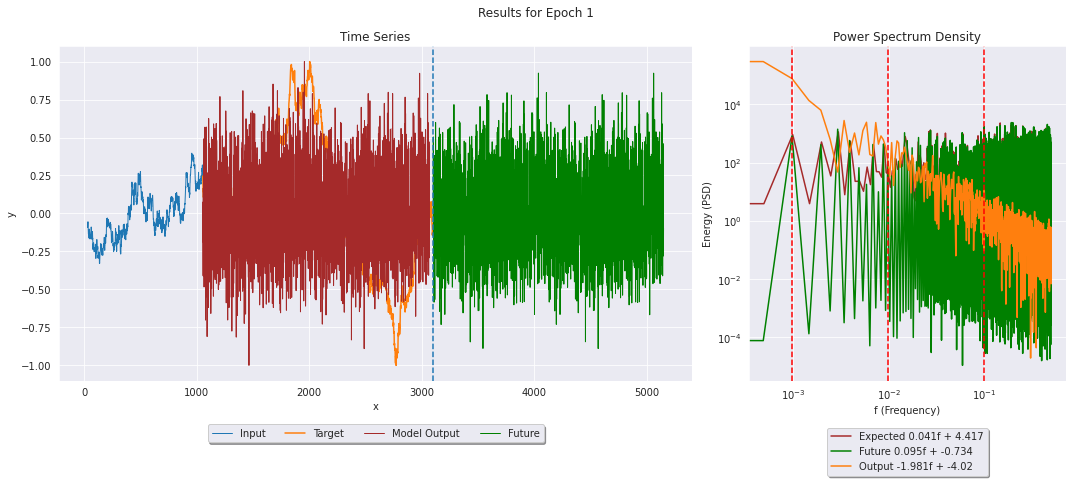

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Epoch: 1, Train Loss: 0.062012601643800735, Validation Loss: 0.19975638389587402, Time 6.382 s


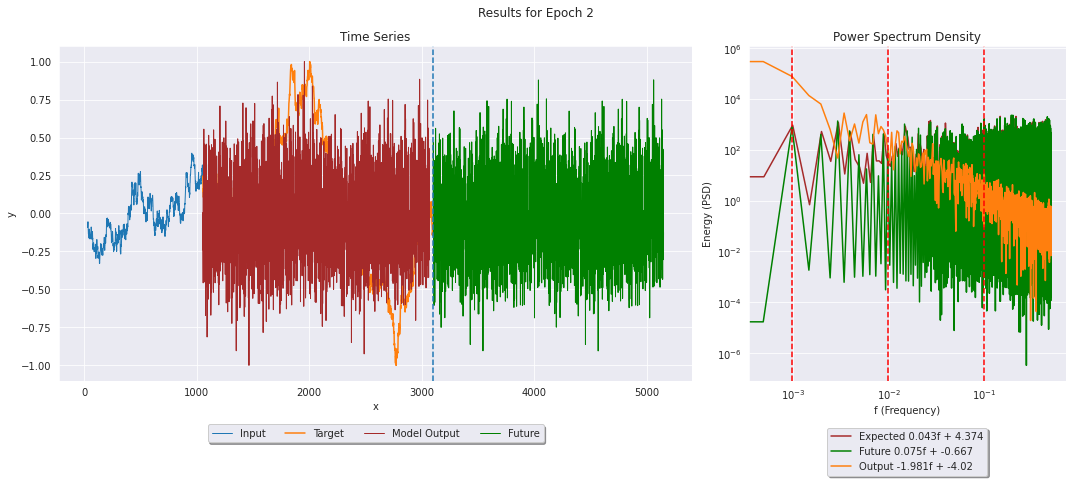

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Epoch: 2, Train Loss: 0.18092013895511627, Validation Loss: 0.17008137702941895, Time 9.034 s


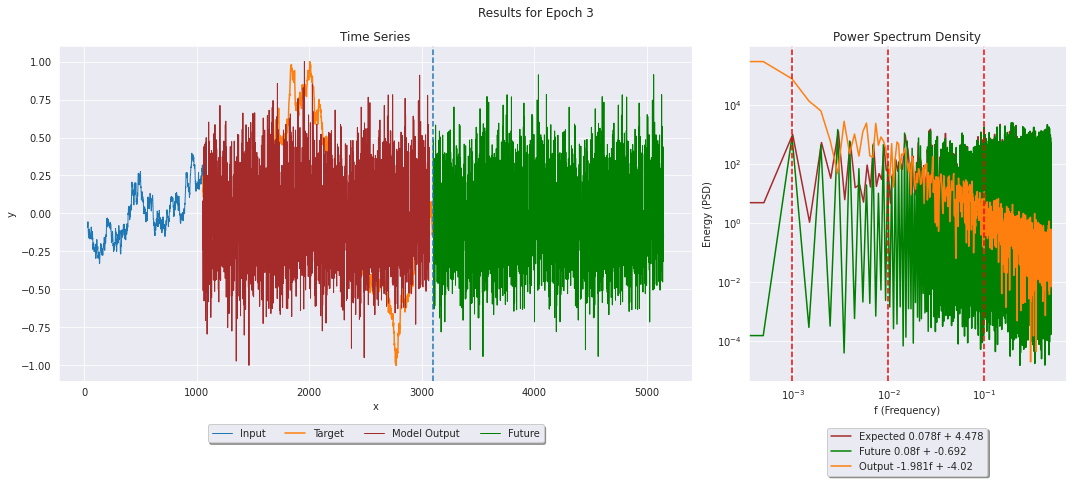

Epoch: 3, Train Loss: 0.04103276878595352, Validation Loss: 0.22124028205871582, Time 13.073 s


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [89]:
n_cut = 3
title = 'MLP'
epochs = 3
low_freq_cut=1
high_freq_cut=1

model = MLP(hidden_size=[1024,1024,1024],
             activations=['tanh','tanh','tanh','tanh'],
             dropouts=[0.0,0.0,0.00,0.0],
            output_size=len(trainY[0])-len(trainX[0]),
            isGNI=True)
#model = MLP(output_size=len(trainY[0]))

optimiser = torch.optim.LBFGS(model.parameters(), lr=0.1)
  # for n_cut in range(1,6):
l = DBeta(n_cut,
          low_freq_cut=low_freq_cut,
          high_freq_cut=high_freq_cut)
training_loop(epochs,model, optimiser,l, 
              trainX.float(), trainY.float(), 
              trainX_test.float(), trainY_test.float(),
              future=len(trainY[0]),
              n_cut=n_cut,
              plot_results_during_traing=True,
              file_name=f'{title}_ncut{n_cut}_GNI.plk')

In [78]:
len(df.fut1)

1024

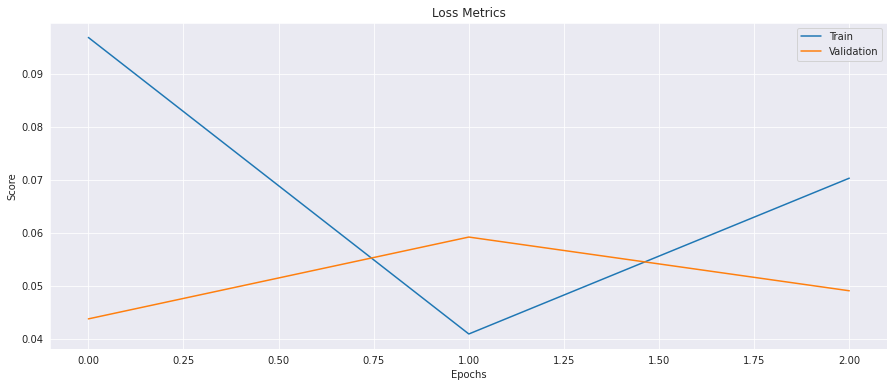

In [74]:
# df = pd.read_pickle('MLP_ncut3_GNI.plk')
# #df
# train = df.loss_train
# valid = df.loss_valid

# plot_loss(train,valid,title='Loss Metrics')

## E2 - RNN

In [68]:
len(trainX)

16

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: RuntimeWarning: divide by zero encountered in log


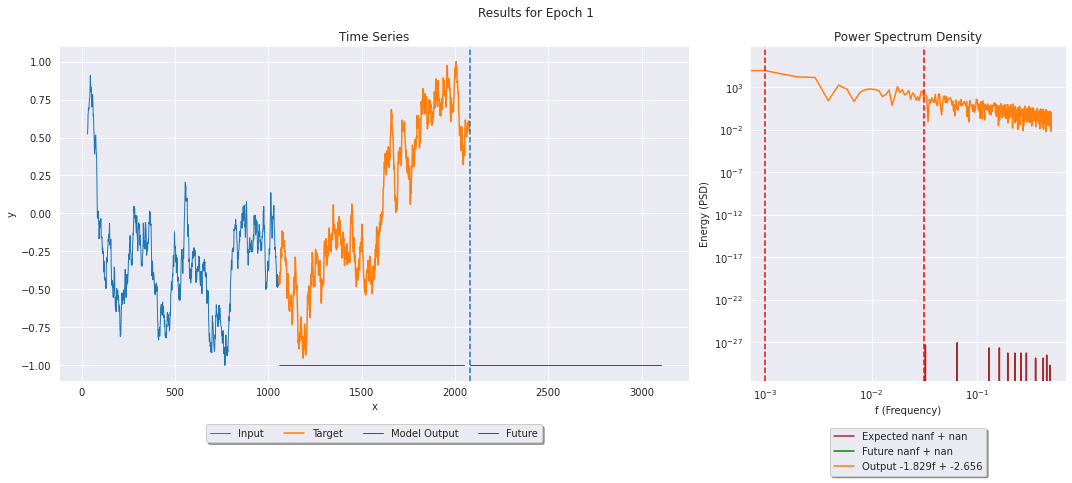

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Epoch: 1, Train Loss: 3.687196731567383, Validation Loss: 3.735492706298828, Time 23.304 s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: RuntimeWarning: divide by zero encountered in log


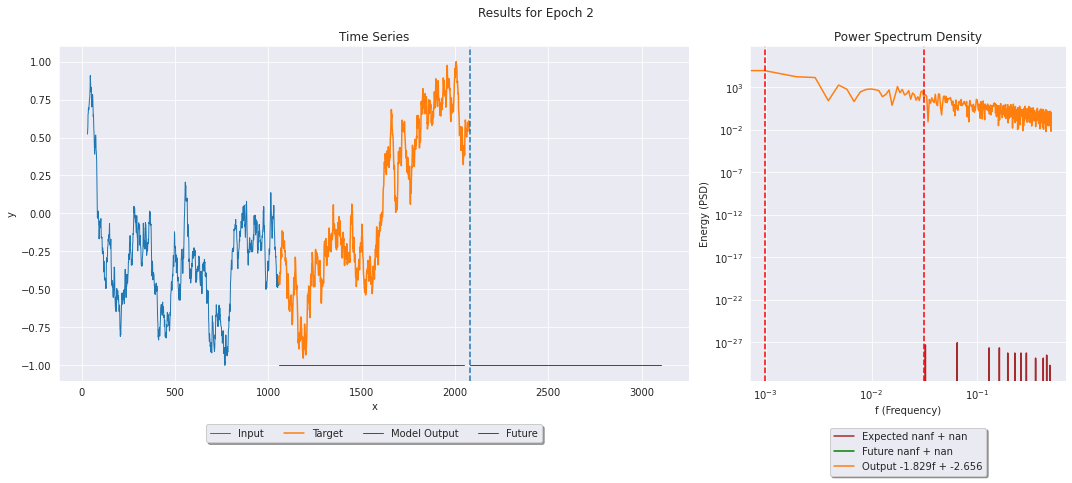

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Epoch: 2, Train Loss: 3.686938524246216, Validation Loss: 3.7353005409240723, Time 22.763 s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: RuntimeWarning: divide by zero encountered in log


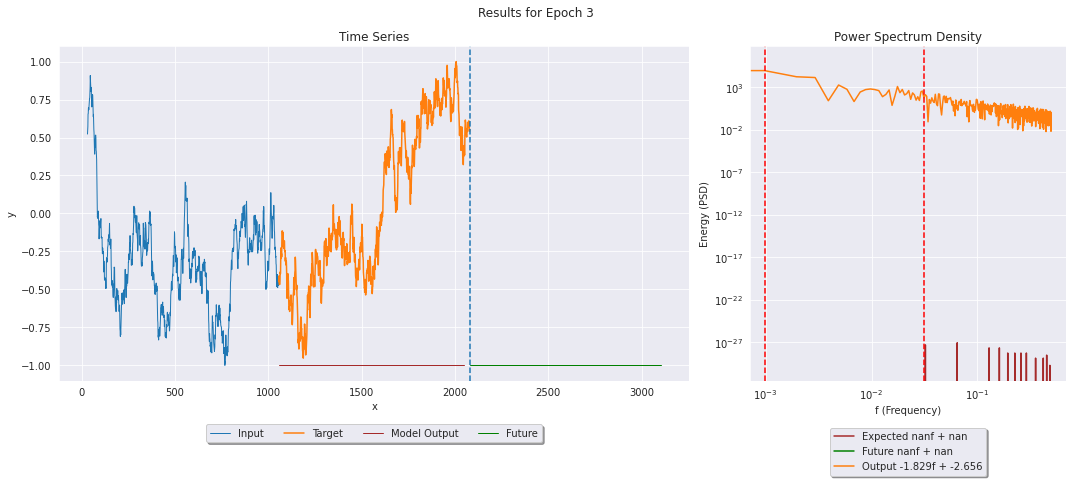

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Epoch: 3, Train Loss: 3.686715602874756, Validation Loss: 3.7350668907165527, Time 22.519 s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: RuntimeWarning: divide by zero encountered in log


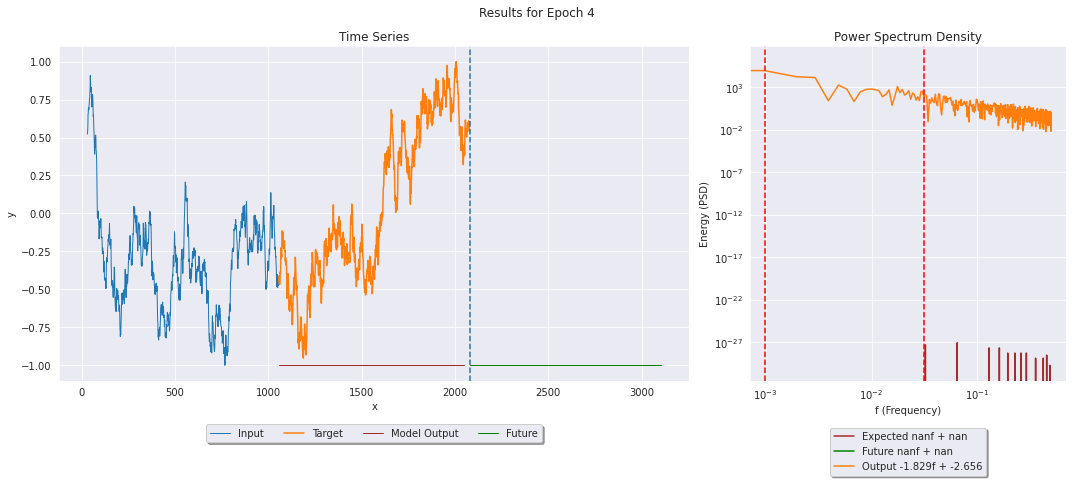

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


Epoch: 4, Train Loss: 3.6864771842956543, Validation Loss: 3.734744071960449, Time 22.702 s


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:193: RuntimeWarning: divide by zero encountered in log


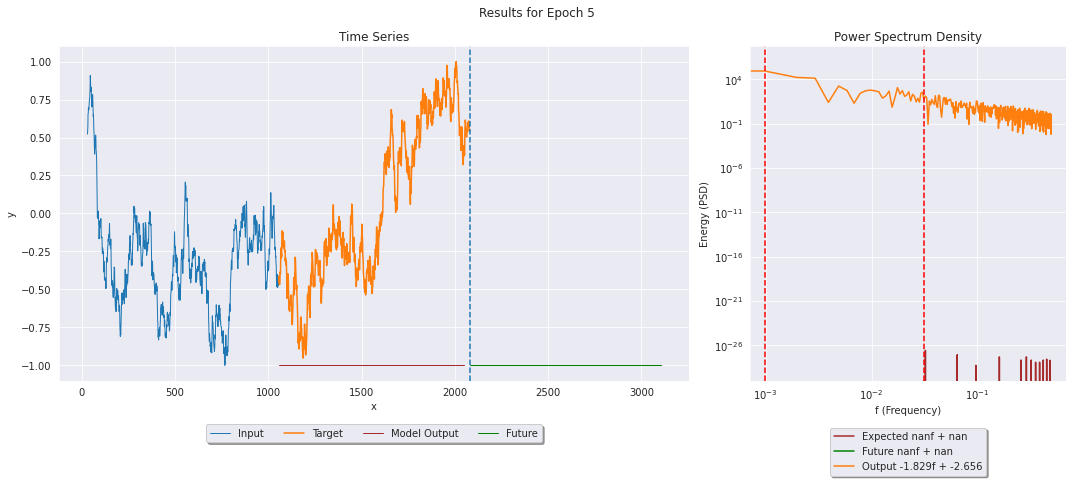

Epoch: 5, Train Loss: 3.6862733364105225, Validation Loss: 3.73447847366333, Time 27.619 s


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [66]:
n_cut = 2
epochs = 5
low_freq_cut=0
high_freq_cut=0
model = RNN_GNI(isGNI=True)
title = 'RNN'

optimiser = torch.optim.LBFGS(model.parameters(), lr=0.1)
  # for n_cut in range(1,6):
l = DBeta(n_cut,
          low_freq_cut=low_freq_cut,
          high_freq_cut=high_freq_cut)
training_loop(epochs,model, optimiser,l, 
              trainX.float(), trainY.float(), 
              trainX_test.float(), trainY_test.float(),
              future=len(trainY[0]),
              n_cut=n_cut,
              plot_results_during_traing=True,
              file_name=f'{title}_ncut{n_cut}_GNI.plk')

In [ ]:
df = pd.read_pickle('LSTM_ncut1.plk')
df

In [ ]:
len(df[~df[f'fut{i+1}'].isnull()][f'fut{i+1}'])

In [ ]:
i = 0
x = df[~df.trainX.isnull()].trainX
y = df[~df.trainY.isnull()].trainY
z = df[~df[f'out{i+1}'].isnull()][f'out{i+1}']
w = df[~df[f'fut{i+1}'].isnull()][f'fut{i+1}']
plot_results(x,y,z,w,32,i)

In [ ]:
# n_cut = 10
# model = [RNN_GNI(isGNI=True)]
# title = 'RNN'
# optimiser = torch.optim.LBFGS(model[i].parameters(), lr=0.1)
#   # for n_cut in range(1,6):
# l = DBeta(n_cut,low_freq_cut=1,high_freq_cut=1)
# training_loop(10,model[i], optimiser,l, trainX.float(), trainY.float(), trainX_test.float(), trainY_test.float(),future=len(trainY[0]),
#             n_cut=n_cut,
#             file_name=f'{title}_ncut{n_cut}_GNI_{i}.plk')

## E3 - LSTM

In [ ]:
n_cut = 2
epochs = 5
low_freq_cut=0
high_freq_cut=0

model = LSTM_GNI(isGNI=True)#model = MLP(output_size=len(trainY[0]))
title = 'LSTM'

optimiser = torch.optim.LBFGS(model.parameters(), lr=0.1)
  # for n_cut in range(1,6):
l = DBeta(n_cut,
          low_freq_cut=low_freq_cut,
          high_freq_cut=high_freq_cut)
training_loop(epochs,model, optimiser,l, 
              trainX.float(), trainY.float(), 
              trainX_test.float(), trainY_test.float(),
              future=len(trainY[0]),
              n_cut=n_cut,
              file_name=f'{title}_ncut{n_cut}_GNI.plk')

IndexError: ignored

## E4 - GRU

In [ ]:
# model = [GRU_GNI(isGNI=False),GRU_GNI(isGNI=True)]
# title = 'GRU'
# for i in range(len(model)):
#   optimiser = torch.optim.LBFGS(model[i].parameters(), lr=0.1)
#   for n_cut in range(1,6):
#     l = DBeta(n_cut)
#     training_loop(30,model[i], optimiser,l, trainX.float(), trainY.float(), trainX_test.float(), trainY_test.float(),future=len(trainY[0]),
#                 n_cut=n_cut,
#                 file_name=f'{title}_ncut{n_cut}_GNI_{i}.plk')

In [ ]:
# plot_loss(train=df[~df.loss_train.isnull()].loss_train,
#           valid=df[~df.loss_valid.isnull()].loss_valid,
#           title='Loss Metrics')


In [ ]:
# df = pd.read_pickle('RNN_model.plk')

In [ ]:
# df = pd.read_pickle('RNN_model.plk')
# plot_results(x = df[~df.trainX.isnull()].trainX,
#              y = df[~df.trainY.isnull()].trainY,
#              z = df[~df[df.columns[epoch+2]].isnull()][df.columns[epoch+2]],
#              w = df[~df[df.columns[epoch+3]].isnull()][df.columns[epoch+3]])


Refazendo o plot da função de treino, pois a do exemplo é muito ruim. Excluimos os 32 iniciais devido a arquitetura da rede, este é o tempo necessário para preencher a memória da primeira camada. 

# Referencias 
[Copyright 2019, Rafael Ballester-Ripoll Revision 8c81a1cb.](https://tntorch.readthedocs.io/en/latest/_modules/metrics.html)

https://blog.paperspace.com/pytorch-loss-functions/

[LSTM and LSTMCell ？ - PyTorch Forums](https://discuss.pytorch.org/t/lstm-and-lstmcell/7488/5)

(Optuna Reference)[https://dl.acm.org/doi/10.1145/3292500.3330701]

In [97]:
"""
Optuna example that optimizes multi-layer perceptrons using PyTorch.
In this example, we optimize the validation accuracy of fashion product recognition using
PyTorch and FashionMNIST. We optimize the neural network architecture as well as the optimizer
configuration. As it is too time consuming to use the whole FashionMNIST dataset,
we here use a small subset of it.
"""

import os

import optuna
from optuna.trial import TrialState
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torchvision import datasets
from torchvision import transforms


DEVICE = torch.device("cpu")
BATCHSIZE = 128
CLASSES = 10
DIR = os.getcwd()
EPOCHS = 10
N_TRAIN_EXAMPLES = BATCHSIZE * 30
N_VALID_EXAMPLES = BATCHSIZE * 10


def define_model(trial):
    # We optimize the number of layers, hidden units and dropout ratio in each layer.
    n_layers = trial.suggest_int("n_layers", 1, 3)
    layers = []

    in_features = 28 * 28
    for i in range(n_layers):
        out_features = trial.suggest_int("n_units_l{}".format(i), 4, 128)
        layers.append(nn.Linear(in_features, out_features))
        layers.append(nn.ReLU())
        p = trial.suggest_float("dropout_l{}".format(i), 0.2, 0.5)
        layers.append(nn.Dropout(p))

        in_features = out_features
    layers.append(nn.Linear(in_features, CLASSES))
    layers.append(nn.LogSoftmax(dim=1))

    return nn.Sequential(*layers)


def get_mnist():
    # Load FashionMNIST dataset.
    train_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(DIR, train=True, download=True, transform=transforms.ToTensor()),
        batch_size=BATCHSIZE,
        shuffle=True,
    )
    valid_loader = torch.utils.data.DataLoader(
        datasets.FashionMNIST(DIR, train=False, transform=transforms.ToTensor()),
        batch_size=BATCHSIZE,
        shuffle=True,
    )

    return train_loader, valid_loader


def objective(trial):

    # Generate the model.
    model = define_model(trial).to(DEVICE)

    # Generate the optimizers.
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr)

    # Get the FashionMNIST dataset.
    train_loader, valid_loader = get_mnist()

    # Training of the model.
    for epoch in range(EPOCHS):
        model.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            # Limiting training data for faster epochs.
            if batch_idx * BATCHSIZE >= N_TRAIN_EXAMPLES:
                break

            data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)

            optimizer.zero_grad()
            output = model(data)
            loss = F.nll_loss(output, target)
            loss.backward()
            optimizer.step()

        # Validation of the model.
        model.eval()
        correct = 0
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(valid_loader):
                # Limiting validation data.
                if batch_idx * BATCHSIZE >= N_VALID_EXAMPLES:
                    break
                data, target = data.view(data.size(0), -1).to(DEVICE), target.to(DEVICE)
                output = model(data)
                # Get the index of the max log-probability.
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()

        accuracy = correct / min(len(valid_loader.dataset), N_VALID_EXAMPLES)

        trial.report(accuracy, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return accuracy


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-11-09 19:14:25,042] A new study created in memory with name: no-name-f05d7952-7db0-44c6-85ac-dcd47bba7b75


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



[I 2022-11-09 19:14:36,828] Trial 0 finished with value: 0.4625 and parameters: {'n_layers': 1, 'n_units_l0': 45, 'dropout_l0': 0.32483727919075545, 'optimizer': 'RMSprop', 'lr': 0.049208480354239616}. Best is trial 0 with value: 0.4625.
[I 2022-11-09 19:14:42,537] Trial 1 finished with value: 0.7078125 and parameters: {'n_layers': 2, 'n_units_l0': 104, 'dropout_l0': 0.49019514178328977, 'n_units_l1': 80, 'dropout_l1': 0.41457153500859373, 'optimizer': 'SGD', 'lr': 0.09790146354304853}. Best is trial 1 with value: 0.7078125.
[I 2022-11-09 19:14:48,035] Trial 2 finished with value: 0.4109375 and parameters: {'n_layers': 1, 'n_units_l0': 16, 'dropout_l0': 0.395773463922034, 'optimizer': 'Adam', 'lr': 3.286781202455302e-05}. Best is trial 1 with value: 0.7078125.
[I 2022-11-09 19:14:53,647] Trial 3 finished with value: 0.2140625 and parameters: {'n_layers': 3, 'n_units_l0': 12, 'dropout_l0': 0.466987206526628, 'n_units_l1': 69, 'dropout_l1': 0.31299002328883757, 'n_units_l2': 6, 'dropout_

KeyboardInterrupt: ignored

In [96]:
import optuna